# Applying OT-intNMF to PBMC

## Imports

In [1]:
# Biology
import scanpy as sc
import anndata as ad
import muon as mu

In [2]:
# Plotting
import matplotlib.pyplot as plt

In [3]:
# Our packages
from scmiot import models, pl, tl

In [4]:
# Maths
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import torch
from torch import optim
from umap import UMAP

In [5]:
# Progress bar
from tqdm.notebook import tqdm

## Load data

In [6]:
mdata = mu.read_h5mu('../datasets/PBMC_10k/preprocessed/pbmc10k.h5mu.gz')

In [7]:
rna = mdata.mod['rna']
atac = mdata.mod['atac']

## Varying genes

In [8]:
sc.pp.highly_variable_genes(rna, min_mean=0.2, max_mean=4, min_disp=0.5, n_top_genes=1000)
np.sum(rna.var.highly_variable)

1000

In [9]:
sc.pp.highly_variable_genes(atac, min_mean=3e-5, max_mean=5e-4, min_disp=0.7, n_top_genes=1000)
np.sum(atac.var.highly_variable)

1000

## Subsample

In [10]:
rna = mdata.mod['rna']
atac = mdata.mod['atac']

In [11]:
sc.pp.subsample(rna, n_obs=800, random_state=0)
sc.pp.subsample(atac, n_obs=800, random_state=0)

In [12]:
# Create MuData object with rna and atac
mdata = mu.MuData({'rna': rna, 'atac': atac})

In [13]:
mu.pp.intersect_obs(mdata)
mdata

MuData object with n_obs × n_vars = 800 × 128106
  var:	'dispersions', 'dispersions_norm', 'highly_variable', 'mean_counts', 'means', 'n_cells_by_counts', 'pct_dropout_by_counts', 'total_counts'
  2 modalities
    rna:	800 x 22020
      obs:	'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg'
    atac:	800 x 106086
      obs:	'celltype', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'atac', 'hvg'

## OT-intNMF

### Train model

In [14]:
# hyperparameters
eps = .1
latent_dim = 20
rho_h = 5e-2
rho_w = 5e-2

In [15]:
nmf = models.OTintNMF(latent_dim=latent_dim, rho_h=rho_h, rho_w=rho_w, eps=eps, cost='cosine')

In [16]:
nmf.fit_transform(mdata, max_iter_inner=2_000, max_iter=100, device='cpu', dtype=torch.float, lr=1, tol_inner=1e-8, tol_outer=1e-5, optim_name='lbfgs')

 18%|█▊        | 36/200 [10:33<48:06, 17.60s/it, loss=0.31560197, loss_inner=-0.00883812, inner_steps=132, gpu_memory_allocated=0]


### Convergence plots

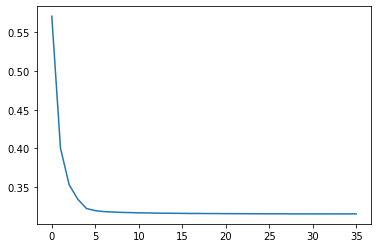

In [17]:
plt.plot(nmf.losses)

### Viz

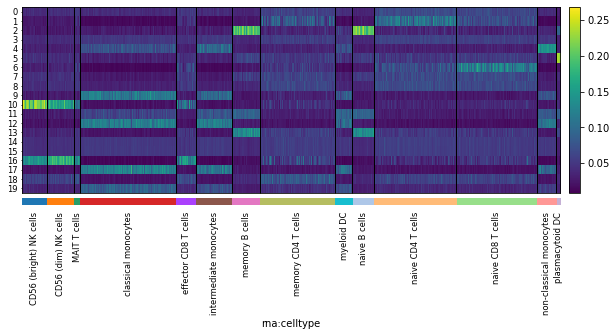

In [18]:
pl.heatmap(mdata, 'W_OT', 'rna:celltype', swap_axes=True)

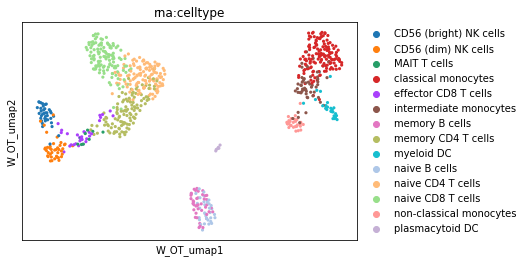

In [19]:
tl.umap(mdata, 'W_OT', metric='l1', min_dist=.6, spread=1)
mu.pl.embedding(mdata, 'W_OT_umap', 'rna:celltype', size=40)

## Clustering

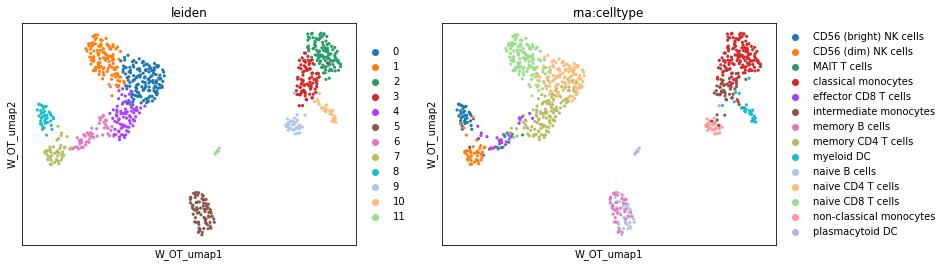

In [29]:
tl.leiden(mdata, resolution=1)
mu.pl.embedding(mdata, 'W_OT_umap', ['leiden', 'rna:celltype'], size=40)

## Enrichment

In [21]:
# Work in progress
tl.enrich(mdata, mod='rna', uns='H_OT', n_genes=700, sources=['GO:MF', 'GO:CC', 'GO:BP'], ordered=True);

                                                name   p_value         query
0  hydrolase activity, acting on carbon-nitrogen ...  0.000068  dimension 17
1  hydrolase activity, acting on carbon-nitrogen ...  0.000117  dimension 12
2  hydrolase activity, acting on carbon-nitrogen ...  0.000119   dimension 9
3  hydrolase activity, acting on carbon-nitrogen ...  0.000151   dimension 4
4  tumor necrosis factor-activated receptor activity  0.000374   dimension 5
5  tumor necrosis factor-activated receptor activity  0.000538   dimension 3
